Notebook corresponding to section 2.3.1 on the external dataset.

Imports

In [45]:
# Local dependencies
from NET_CUP.data_loading.feature_type import FeatureType
from NET_CUP.data_loading import data_tree, xyp
from NET_CUP.utils import general_utils
import NET_CUP.datasources_config as datasources_config

# Other dependencies
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np

Settings

In [46]:
# Adjust these settings
feature_type = FeatureType.MTDP
classifier = SVC()

# Keep these settings
pca = PCA(0.95)
patches_per_patient = 100
uke_dataset_patch_size = 4096
external_dataset_patch_size = 2048 # Resolution is smaller since different scanner is used
border_patches = True

Load data

In [47]:
# UKE dataset as training dataset
train_data = data_tree.create_tree(datasources_config.PATIENTS_PATH,
                             datasources_config.ENUMBER_PATH)
data_tree.drop_slides_without_extracted_features(train_data, feature_type, datasources_config.UKE_DATASET_DIR)
train_patients = data_tree.get_patients(train_data, 'pi')

# External dataset as testing dataset
test_data = data_tree.create_tree(datasources_config.PATIENTS_PATH,
                                  datasources_config.ENUMBER_PATH)
data_tree.drop_slides_without_extracted_features(test_data, feature_type, datasources_config.EXTERNAL_DATASET_DIR)
test_patients = data_tree.get_patients(test_data, 'pi')

Classifier training and testing

In [48]:
y_true_patient_level_complete = xyp.get_patient_level_y(test_patients)
y_pred_patient_level_complete = []

y_true_patch_level_complete = []
y_pred_patch_level_complete = []

# Train patch classifier on UKE dataset
X_train_patch_level, y_train_patch_level, _ = xyp.get_patch_level_Xyp_complete(train_patients, patches_per_patient, feature_type, uke_dataset_patch_size, border_patches, datasources_config.UKE_DATASET_DIR)

X_train_patch_level = pca.fit_transform(X_train_patch_level)
classifier.fit(X_train_patch_level, y_train_patch_level)

# Testing on external dataset
for test_patient in tqdm(test_patients):
    # Get test data
    X_test_patch_level, y_test_patch_level, _ = xyp.get_patch_level_Xyp_complete([test_patient], patches_per_patient, feature_type, external_dataset_patch_size, border_patches, datasources_config.EXTERNAL_DATASET_DIR)

    # Classify patches
    X_test_patch_level = pca.transform(X_test_patch_level)
    y_pred_patch_level = classifier.predict(X_test_patch_level)

    y_true_patch_level_complete.extend(y_test_patch_level)
    y_pred_patch_level_complete.extend(y_pred_patch_level)
    
    # Patient level inference by majority vote
    y_pred_patient_level = np.argmax(np.bincount(y_pred_patch_level))
    y_pred_patient_level_complete.append(y_pred_patient_level)
    

100%|██████████| 9/9 [00:00<00:00,  9.16it/s]


Patch level evaluation

Patch level accuracy: 0.7588888888888888


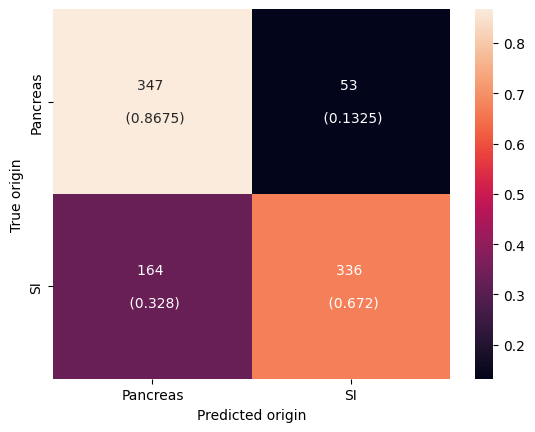

In [49]:
patch_level_accuracy = accuracy_score(y_true_patch_level_complete, y_pred_patch_level_complete)
print(f'Patch level accuracy: {patch_level_accuracy}')

patch_level_confusion_matrix = general_utils.confusion_matrix(y_true_patch_level_complete, y_pred_patch_level_complete, ['Pancreas', 'SI'])


Patient level evaluation

Patient level accuracy: 0.7777777777777778


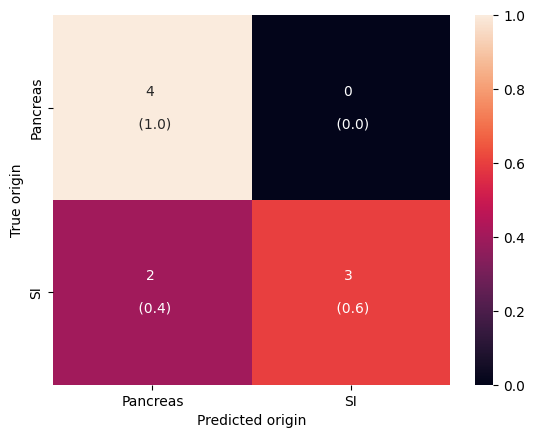

In [50]:
patient_level_accuracy = accuracy_score(y_true_patient_level_complete, y_pred_patient_level_complete)
print(f'Patient level accuracy: {patient_level_accuracy}')

patient_level_confusion_matrix = general_utils.confusion_matrix(y_true_patient_level_complete, y_pred_patient_level_complete, ['Pancreas', 'SI'])
